### Shaded plot

In [2]:
import datetime
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F

from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split
import math

from scipy.linalg import expm, hadamard, signm
import numpy as np

import os

import seaborn as sns

import logging
import math

import matplotlib.pyplot as plt

In [4]:
import sys
sys.path.insert(0, '/home/rahulpadmanabhan/Development/ws1/masters_thesis_2/LAWT/src/neuralnet')
# sys.path.insert(0, '/home/rahulpadmanabhan/Development/ws1/masters_thesis_2/LAWT/src/')
import datagenerator
from models import MatrixFunctionTransformer
from common import get_logger

In [5]:
torch.set_default_dtype(torch.float64)

In [6]:
save_dir = "/mnt/wd_2tb/thesis_transformers/experiments/transformer_wo_embedding/sign/encoder_20240908152543"

In [7]:
logger = get_logger()

In [8]:
# Check if CUDA is available and set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logger.info(f"Using device: {device}")

2024-09-08 20:27:24,901 - root - INFO - Using device: cuda


# Settings

In [9]:
dim = 1
operation = "sign"

In [10]:
test_samples = 2**15  # 16384
k_values = range(5, 19)
train_samples = [(2**k) + test_samples for k in k_values]
dim = dim

In [11]:
logger.info(f"{train_samples=}, {test_samples=}")

relative_errors = []

2024-09-08 20:27:44,957 - root - INFO - train_samples=[32800, 32832, 32896, 33024, 33280, 33792, 34816, 36864, 40960, 49152, 65536, 98304, 163840, 294912], test_samples=32768


In [12]:
train_vals = [2**k for k in range(5, 19)]
models_lst = [*map(lambda x: os.path.join(save_dir, f"dim_{dim}", f'{operation}_model_{str(x)}.pth'), train_vals)]
train_lst = [*map(lambda x: os.path.join(save_dir, f"dim_{dim}", "train", f'train_dataset_{str(x)}.pt'), train_vals)]
test_lst = [*map(lambda x: os.path.join(save_dir, f"dim_{dim}", "test", f'test_dataset_{str(x)}.pt'), train_vals)]

logger.info(f"{models_lst=}\n\n{train_lst=}\n\n{test_lst=}")

2024-09-08 20:27:49,278 - root - INFO - models_lst=['/mnt/wd_2tb/thesis_transformers/experiments/transformer_wo_embedding/sign/encoder_20240908152543/dim_1/sign_model_32.pth', '/mnt/wd_2tb/thesis_transformers/experiments/transformer_wo_embedding/sign/encoder_20240908152543/dim_1/sign_model_64.pth', '/mnt/wd_2tb/thesis_transformers/experiments/transformer_wo_embedding/sign/encoder_20240908152543/dim_1/sign_model_128.pth', '/mnt/wd_2tb/thesis_transformers/experiments/transformer_wo_embedding/sign/encoder_20240908152543/dim_1/sign_model_256.pth', '/mnt/wd_2tb/thesis_transformers/experiments/transformer_wo_embedding/sign/encoder_20240908152543/dim_1/sign_model_512.pth', '/mnt/wd_2tb/thesis_transformers/experiments/transformer_wo_embedding/sign/encoder_20240908152543/dim_1/sign_model_1024.pth', '/mnt/wd_2tb/thesis_transformers/experiments/transformer_wo_embedding/sign/encoder_20240908152543/dim_1/sign_model_2048.pth', '/mnt/wd_2tb/thesis_transformers/experiments/transformer_wo_embedding/sig

In [13]:
test_lst[0]

'/mnt/wd_2tb/thesis_transformers/experiments/transformer_wo_embedding/sign/encoder_20240908152543/dim_1/test/test_dataset_32.pt'

In [16]:
# Load the saved model
model = MatrixFunctionTransformer(dim*dim, dim, 2).to(device)
model.load_state_dict(torch.load(models_lst[0]))
logger.info(model)

/home/rahulpadmanabhan/Development/envs/venv310/lib/python3.10/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
2024-09-08 20:29:12,681 - root - INFO - MatrixFunctionTransformer(
  (encoder1): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=1, out_features=1, bias=True)
        )
        (linear1): Linear(in_features=1, out_features=4, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=4, out_features=1, bias=True)
        (norm1): LayerNorm((1,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((1,), eps=1e-05, elementwise_affine=Tr

In [32]:
models_lst[4]
dim=2
d_model = dim*dim
# Ensure d_model is divisible by nhead
nhead = dim
d_model = (dim // nhead) * nhead
model = MatrixFunctionTransformer(d_model, dim, 2).to(device)
model.load_state_dict(torch.load(models_lst[4]))
model.eval()

MatrixFunctionTransformer(
  (encoder1): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=2, out_features=2, bias=True)
        )
        (linear1): Linear(in_features=2, out_features=8, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=8, out_features=2, bias=True)
        (norm1): LayerNorm((2,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((2,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (encoder2): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=2, out_features=2, bias=True)
        )
        (linear1): Linear(in_featu

In [ ]:
mu_lst = []
sigma_lst = []
y_main_lst = []
u_shaded_lst = []
l_shaded_lst = []
dim=1
for idx, train_val in enumerate(train_vals):

    # Load the saved model
    model = MatrixFunctionTransformer(dim*dim, dim, 2).to(device)
    model.load_state_dict(torch.load(models_lst[idx]))
    model.eval()

    # Loading the test dataset
    test_dataset = torch.load(test_lst[idx])

    logger.info(f"{idx=}\nLoaded model: {models_lst[idx]}")
    logger.info(f"{len(test_dataset)=}")

    actuals = []
    predicted = []

    logger.info(f"Starting to predict values in the test_dataset")
    with torch.no_grad():
        logger.info(f"{dim=}")
        for x, y in test_dataset:
            x = x.view(x.size(0), dim, dim).to(device).to(torch.float64)
            y = y.view(y.size(0), dim, dim).to(device).to(torch.float64)
            # if dim == 1:
                # predicted.append(model(x.view(-1, 1).to(device).to(torch.float64)))
                # actuals.append(y.view(-1,1).to(device).to(torch.float64))
            # else:
                # predicted.append(model(x.view(1, dim*dim).to(device).to(torch.float64)))
                # actuals.append(y.view(1, dim*dim).to(device).to(torch.float64))
                    
            predicted.append(model(x))
            actuals.append(y)
            
        predicted = torch.cat(predicted, 0)
        actuals = torch.cat(actuals, 0)
        
        logger.info(f"\n{predicted.shape=}\n{actuals.shape=}")
        
        np_predicted = predicted.view(-1).cpu().numpy()
        np_actuals = actuals.view(-1).cpu().numpy()

        logger.info(f"{np_predicted.dtype=},{np_actuals.dtype=}")
        
        # mu = np.mean(np.log10(np_predicted))
        y_is = np.abs(np_predicted - np_actuals)/np.abs(np_actuals)
        mu = np.mean(np.log10(y_is))
        sigma = (np_predicted.shape[0] -1)**-1 * np.sum((np.log10(y_is) - mu)**2)
        
        y_main = 10**mu 
        
        u_shaded = 10**(mu - sigma)
        l_shaded = 10**(mu + sigma)
        
        logger.info(f"{mu=},{sigma=}")
        logger.info(f"{y_main=},{u_shaded=},{l_shaded=}")
        
        x_raw = np.repeat(train_vals[idx], np_predicted.shape[0])
        y_raw = np_actuals
        
        logger.info(f"{x_raw.shape=}, {y_raw.shape=}")

        mu_lst.append(mu)
        sigma_lst.append(sigma)
        y_main_lst.append(y_main)
        u_shaded_lst.append(u_shaded)
        l_shaded_lst.append(l_shaded)

In [20]:
mu_lst

[-0.0013934510896096782,
 -0.0020484431633405508,
 -8.297269268441986e-05,
 -0.0018266604598657908,
 -0.0028162535743617547,
 -3.569847129651392e-05,
 -3.536441282237719e-05,
 -4.491267870473629e-05,
 -1.861683493343588e-05,
 -1.6122256048566787e-06,
 -2.0110776320637183e-06,
 8.374134500042419e-06,
 -1.9543187970235032e-05,
 2.246030771939191e-06]

### Rough Sketch

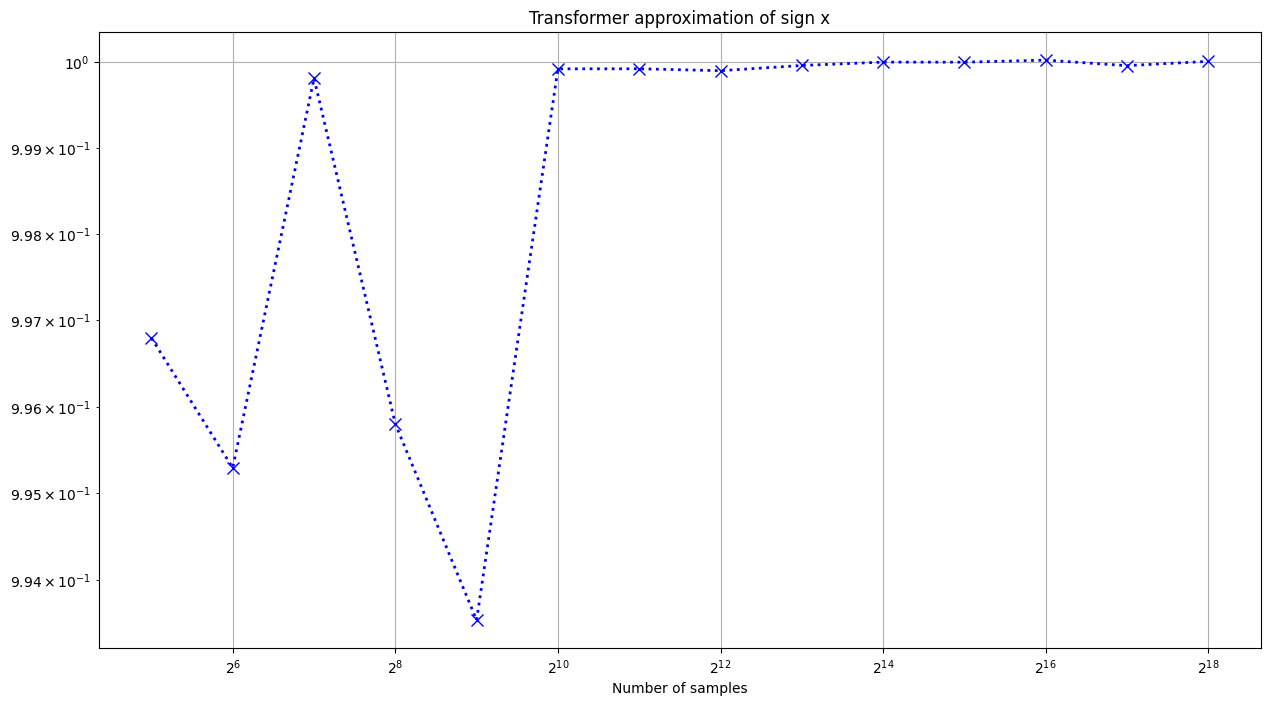

In [23]:
plt.figure(figsize=(15, 8))

plt.grid()
# plt.plot(x_raw, y_raw)
plt.plot(train_vals, 10**np.array(mu_lst), color='blue', marker='x', linestyle='dotted', linewidth=2, markersize=8)
plt.xlabel("Number of samples")


plt.xticks([2**k for k in k_values])
plt.yticks([10**k for k in k_values])
plt.xscale('log', base=2)
plt.yscale('log', base=10)


plt.title("Transformer approximation of sign x")
plt.show()

## Shaded Plot

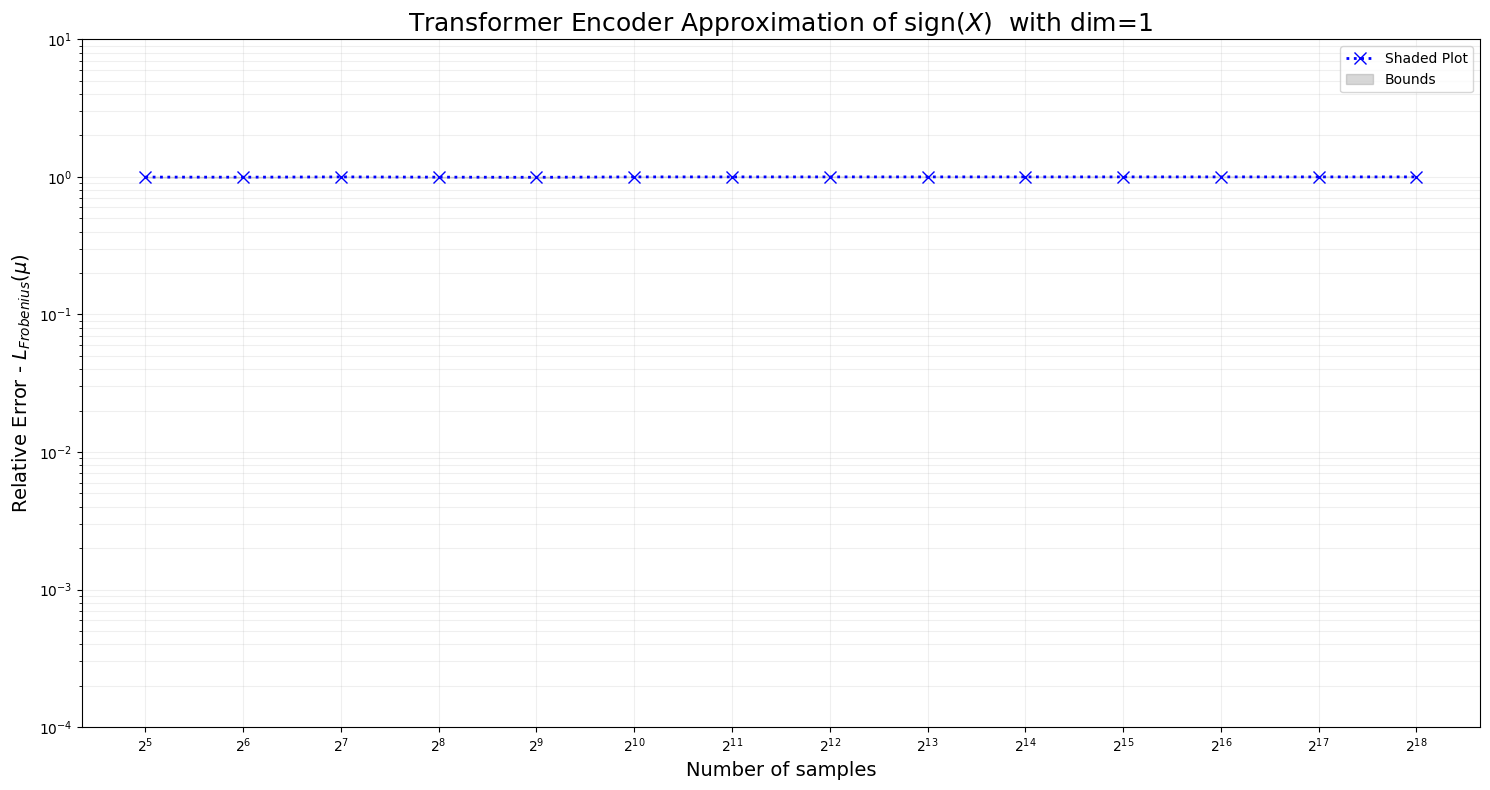

In [25]:
# Your existing data
# train_vals = [32, 64, 128, 256, 512, 1024, 2048, 4096, 8192, 16384, 32768, 65536, 131072, 262144]
# mu_lst = [0.0025189347, -0.0030112644, 0.0018056722, 0.00024630464, -0.0018855985, 0.00081260776, -0.0035950374, -0.0015076925, 0.00010364427, -0.0008442651, 0.00014675909, 0.0005134512, 0.0008943669, 0.00058361713]

# # Upper and lower bounds
# upper_bounds = [0.87437994331586, 0.8589856091986053, 0.8720893378924958, 0.8655245974598067, 0.8616714614469541, 0.866559207650375, 0.8581177330481463, 0.8626829584139304, 0.8656539427892145, 0.8637384055476058, 0.865978438284143, 0.8664403425328335, 0.8658090298992606, 0.8661159388212001]
# lower_bounds = [1.157011517572361, 1.1481313700565632, 1.1562463306422472, 1.156679915576484, 1.1505012466549305, 1.1583157837635798, 1.1462069789816558, 1.151153918054339, 1.1557475383338336, 1.1532653376919344, 1.1555438736045827, 1.1568797971867635, 1.1597559860949047, 1.1576871250884513]

k_values = range(5, 19)

plt.figure(figsize=(15, 8))
plt.grid(True, which="both", ls="-", alpha=0.2)


# Plot the main curve
plt.plot(train_vals, 10**np.array(mu_lst), color='blue', marker='x', linestyle='dotted', linewidth=2, markersize=8, label='Shaded Plot')

u_shaded_lst = [0 if math.isnan(x) else x for x in u_shaded_lst]
l_shaded_lst = [0 if math.isnan(x) else x for x in l_shaded_lst]
# Add the shaded region
plt.fill_between(train_vals, u_shaded_lst, l_shaded_lst, alpha=0.3, color='grey', label='Bounds')

plt.xlabel("Number of samples", fontsize=14)
plt.ylabel(r"Relative Error - $L_{Frobenius}\left(\mu\right)$", fontsize=14)
plt.xscale('log', base=2)
plt.yscale('log', base=10)
plt.title(r"Transformer Encoder Approximation of $\text{sign}\left(X\right)$ " + f" with dim={dim}", fontsize=18)

# Set x-ticks
# plt.xticks([2**k for k in k_values], [f'2^{k}' for k in k_values], rotation=45)
plt.xticks([2**k for k in k_values])
plt.yticks([10**k for k in range(1, -5, -1)])

# Set y-ticks
# y_ticks = [0.8, 0.9, 1.0, 1.1, 1.2]
# plt.yticks(y_ticks, [f'{y:.1f}' for y in y_ticks])

# y_ticks = np.arange(10**0, 10**-4)
# plt.yticks(y_ticks)

# Add legend
plt.legend()

# Adjust layout to prevent cutting off labels
plt.tight_layout()

# plt.savefig(os.path.join(save_dir, f"shaded_plot_dim_{dim}.png"))
# Show the plot


plt.show()

# Loop

In [ ]:
for dim in range(1, 2):

    test_samples = 2**15  # 16384
    k_values = range(5, 19)
    train_samples = [(2**k) + test_samples for k in k_values]
    dim = dim

    logger.info(f"{train_samples=}, {test_samples=}")

    train_vals = [2**k for k in range(5, 19)]
    models_lst = [*map(lambda x: os.path.join(save_dir, f"dim_{dim}", f'{operation}_model_{str(x)}.pth'), train_vals)]
    train_lst = [*map(lambda x: os.path.join(save_dir, f"dim_{dim}", "train", f'train_dataset_{str(x)}.pt'), train_vals)]
    test_lst = [*map(lambda x: os.path.join(save_dir, f"dim_{dim}", "test", f'test_dataset_{str(x)}.pt'), train_vals)]
    
    logger.info(f"{models_lst=}\n\n{train_lst=}\n\n{test_lst=}")

    
    mu_lst = []
    sigma_lst = []
    y_main_lst = []
    u_shaded_lst = []
    l_shaded_lst = []
    for idx, train_val in enumerate(train_vals):
    
        # Load the saved model
        model = MatrixNet(dim*dim).to(device)
        model.load_state_dict(torch.load(models_lst[idx]))
        model.eval()
    
        # Loading the test dataset
        test_dataset = torch.load(test_lst[idx])
    
        logger.info(f"{idx=}\nLoaded model: {models_lst[idx]}")
        logger.info(f"{len(test_dataset)=}")
    
        actuals = []
        predicted = []
    
        logger.info(f"Starting to predict values in the test_dataset")
        with torch.no_grad():
            logger.info(f"{dim=}")
            for x, y in test_dataset:
                if dim == 1:
                    predicted.append(model(x.view(-1, 1).to(device).to(torch.float64)))
                    actuals.append(y.view(-1,1).to(device).to(torch.float64))
                else:
                    predicted.append(model(x.view(1, dim*dim).to(device).to(torch.float64)))
                    actuals.append(y.view(1, dim*dim).to(device).to(torch.float64))
                        
        
            predicted = torch.cat(predicted, 0)
            actuals = torch.cat(actuals, 0)
            
            logger.info(f"\n{predicted.shape=}\n{actuals.shape=}")
            
            np_predicted = predicted.view(-1).cpu().numpy()
            np_actuals = actuals.view(-1).cpu().numpy()
    
            logger.info(f"{np_predicted.dtype=},{np_actuals.dtype=}")
            
            # mu = np.mean(np.log10(np_predicted))
            y_is = np.abs(np_predicted - np_actuals)/np.abs(np_actuals)
            mu = np.mean(np.log10(y_is))
            sigma = (np_predicted.shape[0] -1)**-1 * np.sum((np.log10(y_is) - mu)**2)
            
            y_main = 10**mu 
            
            u_shaded = 10**(mu - sigma)
            l_shaded = 10**(mu + sigma)
            
            logger.info(f"{mu=},{sigma=}")
            logger.info(f"{y_main=},{u_shaded=},{l_shaded=}")
            
            x_raw = np.repeat(train_vals[idx], np_predicted.shape[0])
            y_raw = np_actuals
            
            logger.info(f"{x_raw.shape=}, {y_raw.shape=}")
    
            mu_lst.append(mu)
            sigma_lst.append(sigma)
            y_main_lst.append(y_main)
            u_shaded_lst.append(u_shaded)
            l_shaded_lst.append(l_shaded)
    
    # Plot
    k_values = range(5, 19)
    
    plt.figure(figsize=(15, 8))
    plt.grid(True, which="both", ls="-", alpha=0.2)
    
    
    # Plot the main curve
    plt.plot(train_vals, 10**np.array(mu_lst), color='blue', marker='x', linestyle='dotted', linewidth=2, markersize=8, label='Shaded Plot')
    
    u_shaded_lst = [0 if math.isnan(x) else x for x in u_shaded_lst]
    l_shaded_lst = [0 if math.isnan(x) else x for x in l_shaded_lst]
    # Add the shaded region
    plt.fill_between(train_vals, u_shaded_lst, l_shaded_lst, alpha=0.3, color='grey', label='Bounds')
    
    plt.xlabel("Number of samples", fontsize=14)
    plt.ylabel(r"Relative Error - $L_{Frobenius}\left(\mu\right)$", fontsize=14)
    plt.xscale('log', base=2)
    plt.yscale('log', base=10)
    plt.title(r"Neural Net Approximation of $log\left(X\right) $ " + f" with dim={dim}", fontsize=18)
    
    # Set x-ticks
    # plt.xticks([2**k for k in k_values], [f'2^{k}' for k in k_values], rotation=45)
    plt.xticks([2**k for k in k_values])
    plt.yticks([10**k for k in range(1, -5, -1)])
    
    # Set y-ticks
    # y_ticks = [0.8, 0.9, 1.0, 1.1, 1.2]
    # plt.yticks(y_ticks, [f'{y:.1f}' for y in y_ticks])
    
    # y_ticks = np.arange(10**0, 10**-4)
    # plt.yticks(y_ticks)
    
    # Add legend
    plt.legend()
    
    # Adjust layout to prevent cutting off labels
    plt.tight_layout()
    
    plt.savefig(os.path.join(save_dir, f"Exp_shaded_plot_dim_{dim}_v1.png"))
    # Show the plot

2024-09-08 21:16:34,869 - root - INFO - train_samples=[32800, 32832, 32896, 33024, 33280, 33792, 34816, 36864, 40960, 49152, 65536, 98304, 163840, 294912], test_samples=32768
2024-09-08 21:16:34,870 - root - INFO - models_lst=['/mnt/wd_2tb/thesis_transformers/experiments/transformer_wo_embedding/sign/encoder_20240908152543/dim_2/sign_model_32.pth', '/mnt/wd_2tb/thesis_transformers/experiments/transformer_wo_embedding/sign/encoder_20240908152543/dim_2/sign_model_64.pth', '/mnt/wd_2tb/thesis_transformers/experiments/transformer_wo_embedding/sign/encoder_20240908152543/dim_2/sign_model_128.pth', '/mnt/wd_2tb/thesis_transformers/experiments/transformer_wo_embedding/sign/encoder_20240908152543/dim_2/sign_model_256.pth', '/mnt/wd_2tb/thesis_transformers/experiments/transformer_wo_embedding/sign/encoder_20240908152543/dim_2/sign_model_512.pth', '/mnt/wd_2tb/thesis_transformers/experiments/transformer_wo_embedding/sign/encoder_20240908152543/dim_2/sign_model_1024.pth', '/mnt/wd_2tb/thesis_tran

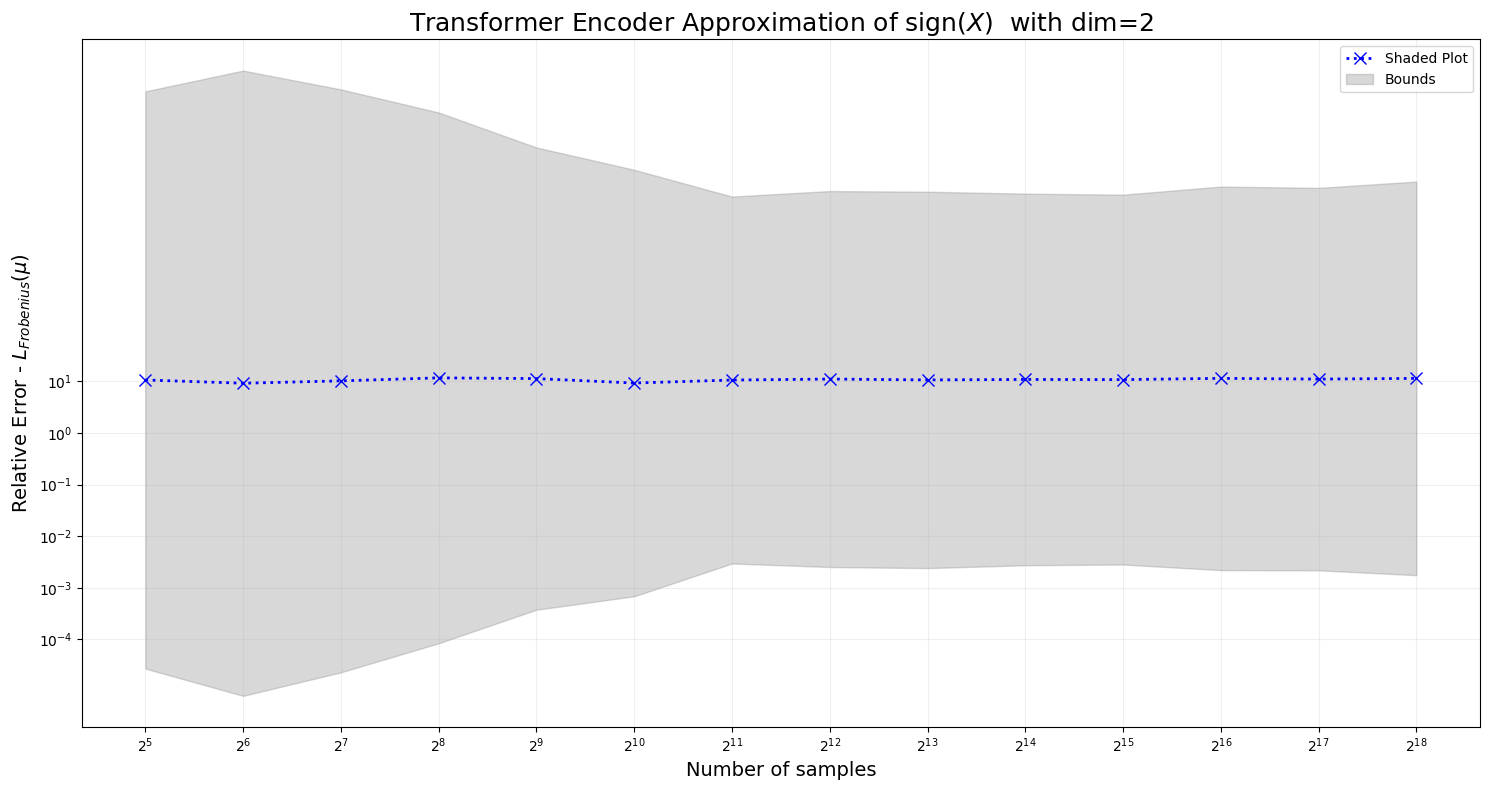

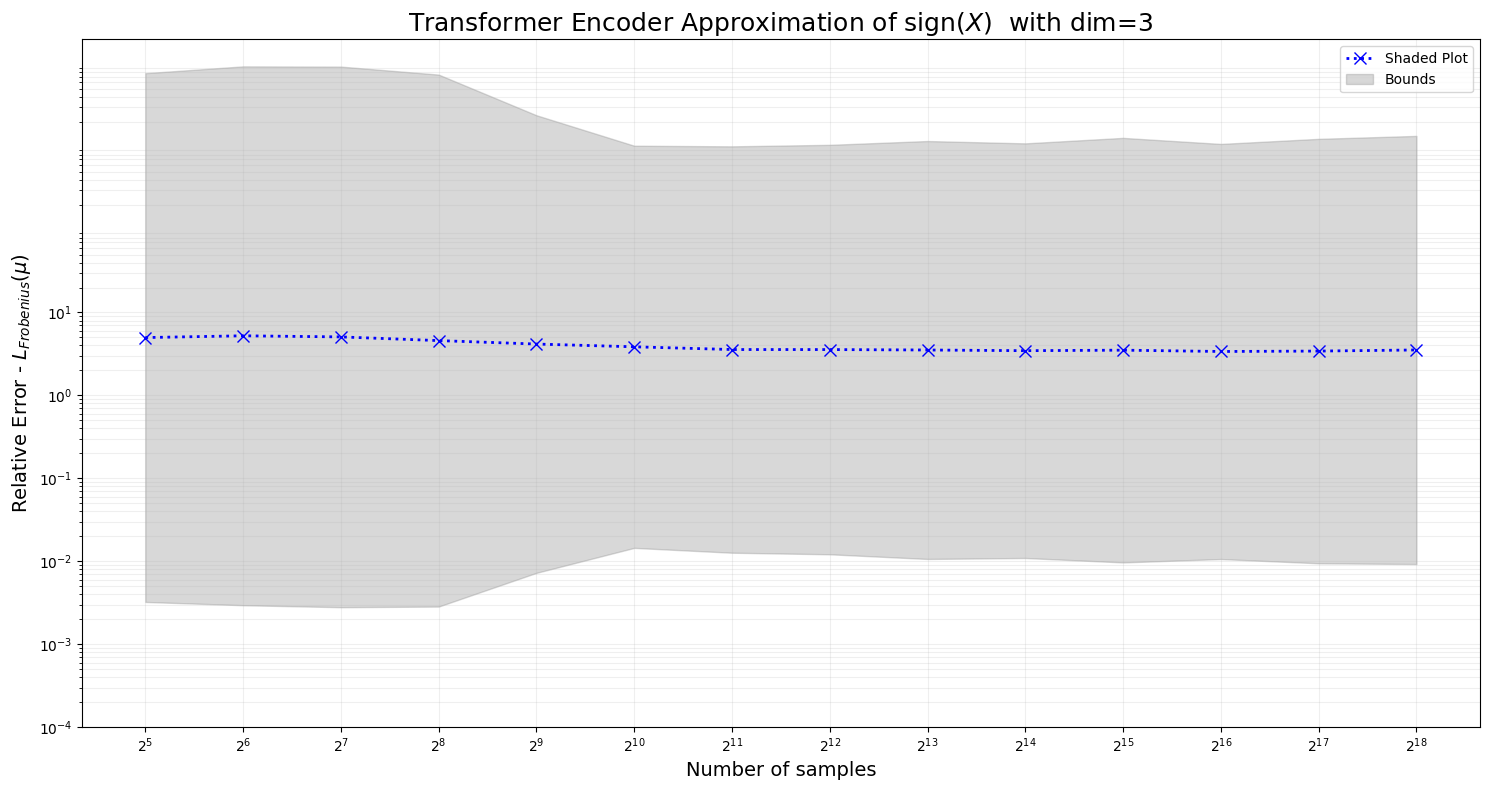

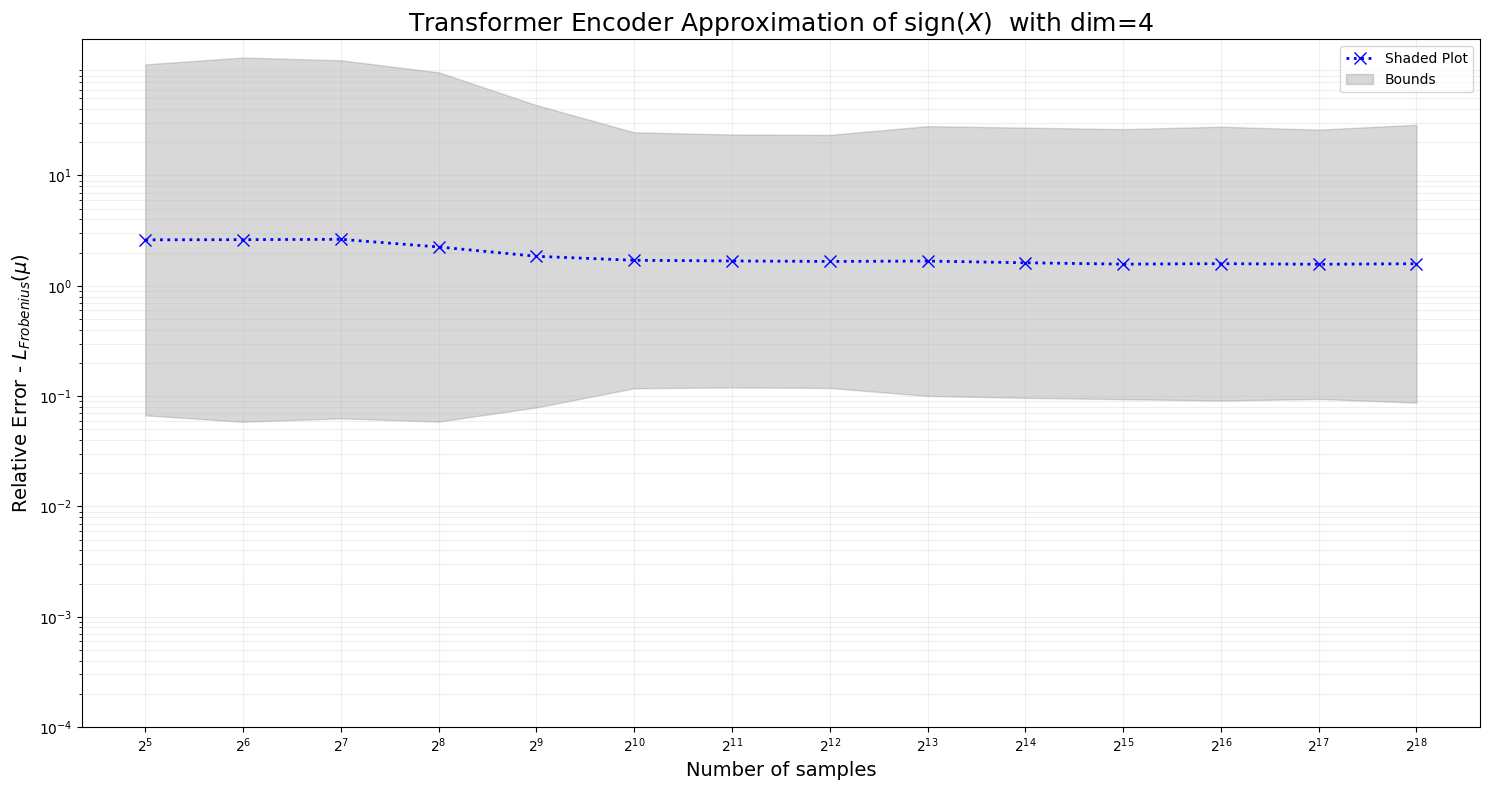

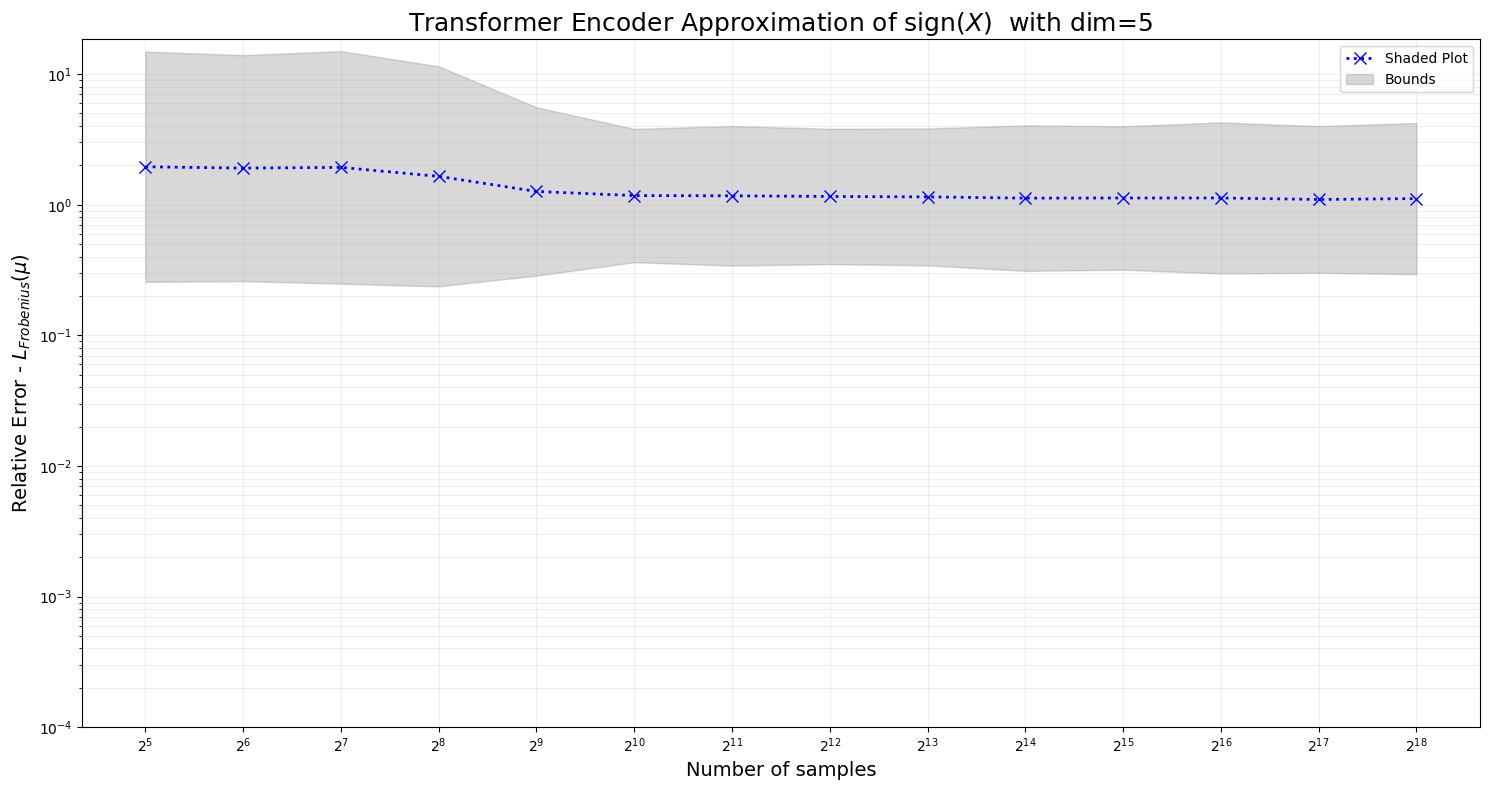

In [38]:
for dim in range(2, 6):
    
    test_samples = 2**15  # 16384
    k_values = range(5, 19)
    train_samples = [(2**k) + test_samples for k in k_values]
    dim = dim

    logger.info(f"{train_samples=}, {test_samples=}")

    train_vals = [2**k for k in range(5, 19)]
    models_lst = [*map(lambda x: os.path.join(save_dir, f"dim_{dim}", f'{operation}_model_{str(x)}.pth'), train_vals)]
    train_lst = [*map(lambda x: os.path.join(save_dir, f"dim_{dim}", "train", f'train_dataset_{str(x)}.pt'), train_vals)]
    test_lst = [*map(lambda x: os.path.join(save_dir, f"dim_{dim}", "test", f'test_dataset_{str(x)}.pt'), train_vals)]
    
    logger.info(f"{models_lst=}\n\n{train_lst=}\n\n{test_lst=}")

    
    mu_lst = []
    sigma_lst = []
    y_main_lst = []
    u_shaded_lst = []
    l_shaded_lst = []
    for idx, train_val in enumerate(train_vals):
    

        d_model = dim*dim
        # Ensure d_model is divisible by nhead
        nhead = dim
        d_model = (dim // nhead) * nhead
        # Load the saved model
        model = MatrixFunctionTransformer(d_model, nhead, 2).to(device)
        model.load_state_dict(torch.load(models_lst[idx]))
        model.eval()
    
        # Loading the test dataset
        test_dataset = torch.load(test_lst[idx])
    
        logger.info(f"{idx=}\nLoaded model: {models_lst[idx]}")
        logger.info(f"{len(test_dataset)=}")
    
        actuals = []
        predicted = []
    
        logger.info(f"Starting to predict values in the test_dataset")
        with torch.no_grad():
            logger.info(f"{dim=}")
            for x, y in test_dataset:
                x = x.view(-1, dim, dim).to(device).to(torch.float64)
                y = y.view(-1, dim, dim).to(device).to(torch.float64)
                predicted.append(model(x))
                actuals.append(y)
                        
        
            predicted = torch.cat(predicted, 0)
            actuals = torch.cat(actuals, 0)
            
            logger.info(f"\n{predicted.shape=}\n{actuals.shape=}")
            
            np_predicted = predicted.view(-1).cpu().numpy()
            np_actuals = actuals.view(-1).cpu().numpy()
    
            logger.info(f"{np_predicted.dtype=},{np_actuals.dtype=}")
            
            # mu = np.mean(np.log10(np_predicted))
            y_is = np.abs(np_predicted - np_actuals)/(np.abs(np_actuals) + 1e-5)
            mu = np.mean(np.log10(y_is))
            sigma = (np_predicted.shape[0] -1)**-1 * np.sum((np.log10(y_is) - mu)**2)
            
            y_main = 10**mu 
            
            u_shaded = 10**(mu - sigma)
            l_shaded = 10**(mu + sigma)
            
            logger.info(f"{mu=},{sigma=}")
            logger.info(f"{y_main=},{u_shaded=},{l_shaded=}")
            
            x_raw = np.repeat(train_vals[idx], np_predicted.shape[0])
            y_raw = np_actuals
            
            logger.info(f"{x_raw.shape=}, {y_raw.shape=}")
    
            mu_lst.append(mu)
            sigma_lst.append(sigma)
            y_main_lst.append(y_main)
            u_shaded_lst.append(u_shaded)
            l_shaded_lst.append(l_shaded)
    
    # Plot
    k_values = range(5, 19)
    
    plt.figure(figsize=(15, 8))
    plt.grid(True, which="both", ls="-", alpha=0.2)
    
    
    # Plot the main curve
    plt.plot(train_vals, 10**np.array(mu_lst), color='blue', marker='x', linestyle='dotted', linewidth=2, markersize=8, label='Shaded Plot')
    
    u_shaded_lst = [0 if math.isnan(x) else x for x in u_shaded_lst]
    l_shaded_lst = [0 if math.isnan(x) else x for x in l_shaded_lst]
    # Add the shaded region
    plt.fill_between(train_vals, u_shaded_lst, l_shaded_lst, alpha=0.3, color='grey', label='Bounds')
    
    plt.xlabel("Number of samples", fontsize=14)
    plt.ylabel(r"Relative Error - $L_{Frobenius}\left(\mu\right)$", fontsize=14)
    plt.xscale('log', base=2)
    plt.yscale('log', base=10)
    plt.title(r"Transformer Encoder Approximation of $\text{sign}\left(X\right) $ " + f" with dim={dim}", fontsize=18)
    
    # Set x-ticks
    # plt.xticks([2**k for k in k_values], [f'2^{k}' for k in k_values], rotation=45)
    plt.xticks([2**k for k in k_values])
    plt.yticks([10**k for k in range(1, -5, -1)])
    
    # Set y-ticks
    # y_ticks = [0.8, 0.9, 1.0, 1.1, 1.2]
    # plt.yticks(y_ticks, [f'{y:.1f}' for y in y_ticks])
    
    # y_ticks = np.arange(10**0, 10**-4)
    # plt.yticks(y_ticks)
    
    # Add legend
    plt.legend()
    
    # Adjust layout to prevent cutting off labels
    plt.tight_layout()
    
    plt.savefig(os.path.join(save_dir, f"TransformerEncoder_shaded_plot_dim_{dim}_v1.png"))
    # Show the plot